In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms


batch_size = 32

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ContractiveAutoencoder(nn.Module):
    def __init__(self):
        super(ContractiveAutoencoder, self).__init__()
        # Encoder layers
        self.flatten = nn.Flatten()
        self.encoder_fc1 = nn.Linear(28 * 28, 64)
        self.encoder_fc2 = nn.Linear(64, 32)
        self.bottleneck = nn.Linear(32, 16)  # bottleneck layer

        # Decoder layers
        self.decoder_fc1 = nn.Linear(16, 32)
        self.decoder_fc2 = nn.Linear(32, 64)
        self.output_fc = nn.Linear(64, 28 * 28)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.encoder_fc1(x))
        x = F.relu(self.encoder_fc2(x))
        h = F.relu(self.bottleneck(x))  # Latent representation (bottleneck)

        x = F.relu(self.decoder_fc1(h))
        x = F.relu(self.decoder_fc2(x))
        x = self.output_fc(x)
        x = x.view(x.size(0), 1, 28, 28)

        return x, h

In [ ]:
def contractive_loss(x, x_reconstructed, h, model, Lambda=100):
    # Reconstruction loss
    mse_loss = F.mse_loss(x_reconstructed, x, reduction='sum')

    # Contractive loss
    dh = h * (1 - h)
    W = model.bottleneck.weight
    contractive = Lambda * torch.sum(dh ** 2 * torch.sum(W ** 2, dim=1))

    total_loss = mse_loss + contractive
    return total_loss
model = ContractiveAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:


# Training loop
num_epochs = 15  # Adjust as needed
loss_array = []
Lambda = 100  # Contractive regularization weight
dataiter = iter(testloader)

for epoch in range(num_epochs):
    for i, (x_batch, label) in enumerate(trainloader):
        x_batch = x_batch.to(device)

        # Forward pass
        x_reconstructed, h = model(x_batch)

        # Compute loss and gradients
        loss = contractive_loss(x_batch, x_reconstructed, h, model, Lambda)
        loss_array.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

Epoch [1/15], Loss: 779.6744995117188
Epoch [2/15], Loss: 610.207275390625
Epoch [3/15], Loss: 668.0921630859375
Epoch [4/15], Loss: 569.341552734375
Epoch [5/15], Loss: 605.8126220703125
Epoch [6/15], Loss: 605.3224487304688
Epoch [7/15], Loss: 630.3350830078125
Epoch [8/15], Loss: 635.09375
Epoch [9/15], Loss: 511.630126953125
Epoch [10/15], Loss: 584.6310424804688
Epoch [11/15], Loss: 621.0588989257812
Epoch [12/15], Loss: 572.6546630859375
Epoch [13/15], Loss: 637.6160278320312
Epoch [14/15], Loss: 659.2431030273438
Epoch [15/15], Loss: 538.6441040039062


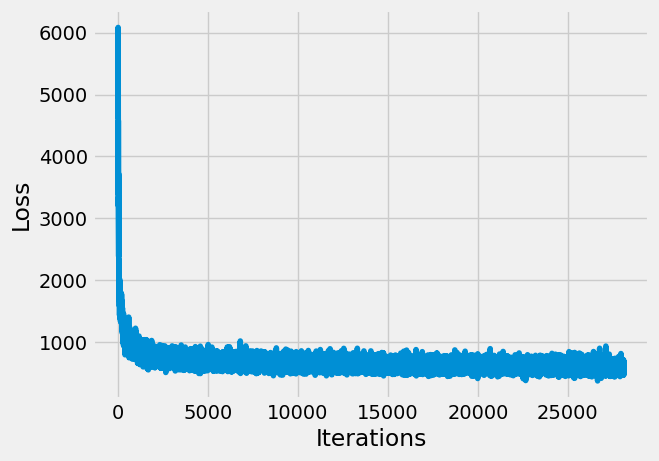

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

num_losses = []

for x in loss_array:
    num_losses.append(x.item())

plt.plot(num_losses)

In [ ]:
from PIL import Image
from matplotlib import cm
import numpy as np
to_pil_image = transforms.ToPILImage()
pil_image = to_pil_image(testset[0][0])
pil_image

In [ ]:
x_reconstructed, h = model(testset[0][0])
print(x_reconstructed.shape)
to_pil_image(x_reconstructed.squeeze(0))

torch.Size([1, 1, 28, 28])


In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()

# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data", train = True, download = True, transform = tensor_transform)

# DataLoader is used to load the dataset
# for training
loader = torch.utils.data.DataLoader(dataset = dataset, batch_size = 30, shuffle = True)

device = torch.device("cuda")

In [ ]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
# Model Initialization
model = AE().to(device)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
epochs = 40
outputs = []
losses = []

print("Start Training")
for epoch in range(epochs):
    print("Epoch " + str(epoch))
    for image in loader:
        # Flattening the image
        image = image.reshape(-1, 28 * 28).to(device)

        # Sending the image to the device
        image = image.to("mps")

        # Output of Autoencoder
        reconstructed = model(image)

        # Calculating the loss function
        loss = loss_function(reconstructed, image)

        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        losses.append(loss)
    outputs.append((epochs, image, reconstructed))

In [ ]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

num_losses = []

for x in losses:
    num_losses.append(x.item())

# Plotting the last 100 values
plt.plot(num_losses[-100:])

In [ ]:
for i, item in enumerate(image):
  # Reshape the array for plotting
  item = item.reshape(-1, 28, 28)
  item = item.to("cpu").detach().numpy()
  plt.imshow(item[0])

In [ ]:
for i, item in enumerate(reconstructed):
  item = item.reshape(-1, 28, 28)
  item = item.to("cpu").detach().numpy()
  plt.imshow(item[0])